In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torchvision.transforms import ToTensor
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import cv2
import os
from torch.utils.data import TensorDataset, DataLoader
import matplotlib as plt
%matplotlib inline
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from glob import glob
from skimage.io import imread
from os import listdir
import time
import copy
import random

C:\Users\alvaro.rlanceta\AppData\Local\anaconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
root_dir = "\\DatasetPacientes"  # Ruta del directorio de imágenes DatasetPacientes

N_IDC = []
P_IDC = []

for dir_name in tqdm(os.listdir(root_dir)):
    dir_path = os.path.join(root_dir, dir_name)
    if os.path.isdir(dir_path):
        negative_dir_path = os.path.join(dir_path, '0')
        positive_dir_path = os.path.join(dir_path, '1')
        if os.path.isdir(negative_dir_path) and os.path.isdir(positive_dir_path):
            negative_image_paths = [
                os.path.join(negative_dir_path, image_name)
                for image_name in os.listdir(negative_dir_path)
                if image_name.endswith('.png')
            ]
            positive_image_paths = [
                os.path.join(positive_dir_path, image_name)
                for image_name in os.listdir(positive_dir_path)
                if image_name.endswith('.png')
            ]
            N_IDC.extend(negative_image_paths)
            P_IDC.extend(positive_image_paths)

total_images = 5000  

n_img_arr = np.zeros(shape=(total_images, 50, 50, 3), dtype=np.float32)
p_img_arr = np.zeros(shape=(total_images, 50, 50, 3), dtype=np.float32)
label_n = np.zeros(total_images)
label_p = np.ones(total_images)

for i, img in tqdm(enumerate(N_IDC[:total_images])):
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    n_img_arr[i] = n_img_size

for i, img in tqdm(enumerate(P_IDC[:total_images])):
    p_img = cv2.imread(img, cv2.IMREAD_COLOR)
    p_img_size = cv2.resize(p_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    p_img_arr[i] = p_img_size

X = np.concatenate((p_img_arr, n_img_arr), axis=0)
y = np.concatenate((label_p, label_n), axis=0)
X, y = shuffle(X, y, random_state=0)

# probar --> y = to_categorical(y)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)


  0%|          | 0/280 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [3]:
len(X_train)

7200

In [4]:


class CNN(nn.Module):
    def __init__(self, output_size=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(p=0.3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(12 * 12 * 64, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 64)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(64, 24)
        self.fc4 = nn.Linear(24, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn5(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [5]:

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    return train_loss

def evaluate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader)
    accuracy = 100.0 * correct / len(val_loader.dataset)
    return val_loss, accuracy

In [6]:
import datetime

# Tiempo inicial
start_time = datetime.datetime.now()
batch_size = 32  # Define the batch size
train_dataset = TensorDataset(torch.from_numpy(X_train).float().permute(0, 3, 1, 2), torch.from_numpy(y_train).long())
val_dataset = TensorDataset(torch.from_numpy(X_val).float().permute(0, 3, 1, 2), torch.from_numpy(y_val).long())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 40
best_val_loss = float('inf')
losses = {"train": [], "val": []}
hist = {"train": [], "val": []}

for epoch in range(num_epochs):
    train_loss = train(model, device, train_loader, optimizer, criterion)
    val_loss, val_accuracy = evaluate(model, device, val_loader, criterion)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    hist["train"].append(val_accuracy)
    hist["val"].append(val_accuracy)

    print('Epoch: {:02d}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.2f}%'.format(
        epoch, train_loss, val_loss, val_accuracy))

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))



Epoch: 00, Train Loss: 0.4727, Val Loss: 0.4791, Val Accuracy: 82.50%
Epoch: 01, Train Loss: 0.4559, Val Loss: 0.4543, Val Accuracy: 85.00%
Epoch: 02, Train Loss: 0.4437, Val Loss: 0.5053, Val Accuracy: 79.00%
Epoch: 03, Train Loss: 0.4425, Val Loss: 0.5474, Val Accuracy: 76.44%
Epoch: 04, Train Loss: 0.4469, Val Loss: 0.4774, Val Accuracy: 83.28%
Epoch: 05, Train Loss: 0.4432, Val Loss: 0.5062, Val Accuracy: 80.44%
Epoch: 06, Train Loss: 0.4411, Val Loss: 0.5208, Val Accuracy: 77.78%
Epoch: 07, Train Loss: 0.4337, Val Loss: 0.5213, Val Accuracy: 77.83%
Epoch: 08, Train Loss: 0.4337, Val Loss: 0.6834, Val Accuracy: 61.44%
Epoch: 09, Train Loss: 0.4290, Val Loss: 0.4413, Val Accuracy: 87.11%
Epoch: 10, Train Loss: 0.4305, Val Loss: 0.5174, Val Accuracy: 79.06%
Epoch: 11, Train Loss: 0.4295, Val Loss: 0.4825, Val Accuracy: 81.22%
Epoch: 12, Train Loss: 0.4295, Val Loss: 0.4444, Val Accuracy: 86.56%
Epoch: 13, Train Loss: 0.4273, Val Loss: 0.5335, Val Accuracy: 76.83%
Epoch: 14, Train Los

<All keys matched successfully>

In [7]:
end_time = datetime.datetime.now()

# Calculando la diferencia de tiempo
duration = end_time - start_time

print(f"Tiempo de ejecución: {duration}")

Tiempo de ejecución: 0:10:17.605686


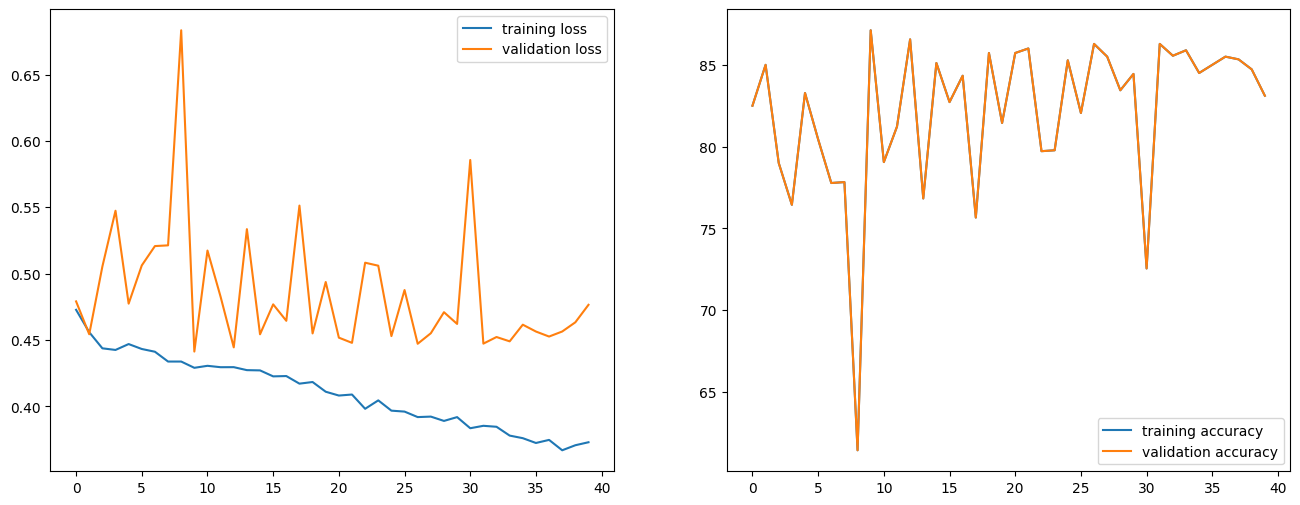

In [8]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(losses["train"], label="training loss")
ax1.plot(losses["val"], label="validation loss")
ax1.legend()

ax2.plot(hist["train"], label="training accuracy")
ax2.plot(hist["val"], label="validation accuracy")
ax2.legend()

plt.show()

In [9]:
# Evaluate on the test set
test_dataset = TensorDataset(torch.from_numpy(X_test).float().permute(0, 3, 1, 2), torch.from_numpy(y_test).long())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loss, test_accuracy = evaluate(model, device, test_loader, criterion)

print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, test_accuracy))

Test Loss: 0.4423, Test Accuracy: 87.30%


In [10]:
from sklearn.metrics import classification_report

test_dataset = TensorDataset(torch.from_numpy(X_test).float().permute(0, 3, 1, 2), torch.from_numpy(y_test).long())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
def evaluate_and_predict(model, device, loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    return all_targets, all_preds
y_true, y_pred = evaluate_and_predict(model, device, test_loader)
report = classification_report(y_true, y_pred, target_names=['0', '1'])  # Adjust class names as needed
print(report)


              precision    recall  f1-score   support

           0       0.85      0.89      0.87       480
           1       0.90      0.85      0.87       520

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



### Visualize the results

In [62]:
#Iterate over the test data and make predictions
list_img_names = []
results_dict = {}

counter = 0
for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    for j in range(inputs.size(0)):
        # Obtener el nombre de la imagen
        image_index = i * test_loader.batch_size + j
        image_path = N_IDC[image_index] if preds[j].item() == 0 else P_IDC[image_index]
        image_name = os.path.basename(image_path)
        print("Nombre de la imagen: {}".format(image_name))
        list_img_names.append(image_name)

        # Cargar y mostrar la imagen
        image = inputs[j].permute(1, 2, 0).cpu().numpy()

        # Normalizar la imagen
        image = (image - image.min()) / (image.max() - image.min())

        """
        plt.figure()
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        """
        
        # Obtener la predicción y la etiqueta correcta
        prediction = preds[j].item()
        correct_label = labels[j].item()
        print("Predicción: {}, Etiqueta correcta: {}".format(prediction, correct_label), "\n")

        # Agregar la información al diccionario
        results_dict[image_name] = [prediction, correct_label]

# Imprimir el diccionario para verificar los resultados
print(results_dict)

Nombre de la imagen: 10253_idx5_x501_y351_class1.png
Predicción: 1, Etiqueta correcta: 1 

Nombre de la imagen: 10253_idx5_x1001_y1051_class0.png
Predicción: 0, Etiqueta correcta: 0 

Nombre de la imagen: 10253_idx5_x551_y301_class1.png
Predicción: 1, Etiqueta correcta: 1 

Nombre de la imagen: 10253_idx5_x551_y351_class1.png
Predicción: 1, Etiqueta correcta: 0 

Nombre de la imagen: 10253_idx5_x551_y401_class1.png
Predicción: 1, Etiqueta correcta: 1 

Nombre de la imagen: 10253_idx5_x551_y451_class1.png
Predicción: 1, Etiqueta correcta: 0 

Nombre de la imagen: 10253_idx5_x1001_y1301_class0.png
Predicción: 0, Etiqueta correcta: 0 

Nombre de la imagen: 10253_idx5_x551_y701_class1.png
Predicción: 1, Etiqueta correcta: 1 

Nombre de la imagen: 10253_idx5_x601_y251_class1.png
Predicción: 1, Etiqueta correcta: 1 

Nombre de la imagen: 10253_idx5_x1001_y1551_class0.png
Predicción: 0, Etiqueta correcta: 0 

Nombre de la imagen: 10253_idx5_x1001_y1701_class0.png
Predicción: 0, Etiqueta corre

In [52]:
X_test

array([[[[122.,  72., 179.],
         [131.,  74., 183.],
         [139.,  83., 186.],
         ...,
         [148.,  98., 196.],
         [172., 128., 200.],
         [171., 125., 191.]],

        [[128.,  76., 192.],
         [130.,  80., 191.],
         [145.,  97., 190.],
         ...,
         [153., 106., 187.],
         [143.,  93., 198.],
         [144.,  93., 199.]],

        [[113.,  64., 189.],
         [116.,  70., 194.],
         [122.,  71., 193.],
         ...,
         [152., 106., 200.],
         [182., 143., 204.],
         [154., 107., 201.]],

        ...,

        [[139.,  77., 135.],
         [133.,  75., 127.],
         [139.,  80., 134.],
         ...,
         [150.,  97., 186.],
         [144.,  99., 151.],
         [164., 122., 182.]],

        [[122.,  57., 113.],
         [128.,  74., 129.],
         [133.,  80., 128.],
         ...,
         [144.,  93., 199.],
         [155., 100., 187.],
         [164., 105., 190.]],

        [[182., 136., 180.],
       

In [50]:
model.eval()

# Diccionario para almacenar las predicciones
predictions_dict = {}

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        # Obtener las predicciones del modelo
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Asociar cada archivo con su predicción
        start_index = i * batch_size
        end_index = start_index + inputs.size(0)
        
        for idx, prediction in enumerate(predicted):
            file_name = file_names[start_index + idx]
            predictions_dict[file_name] = prediction.item()

print(predictions_dict)



NameError: name 'file_names' is not defined

In [63]:
patient_ids = []
for name in list_img_names:
    id = name.split('_')[0]
    patient_ids.append(id)

In [13]:
ids_unique = list(set(patient_ids))


In [14]:
base_path = root_dir

In [15]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from sklearn.utils.class_weight import compute_class_weight

from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm
import random




In [16]:
def get_cancer_dataframe(patient_id, cancer_id):
    path = os.path.join(base_path, patient_id, cancer_id)
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = [os.path.join(path, filename) for filename in dataframe.filename.values]
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = pd.concat([df_0, df_1], ignore_index=True)
    return patient_df

In [74]:
def visualise_breast_tissue_base(patient_id, pred_df=None):
    print("PATIENT", patient_id)
    example_df = get_patient_dataframe(patient_id)
    print("EXAMPLE", example_df)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape=(max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape=(max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape=(max_point[0] + 50, max_point[1] + 50, 1)).astype(float)
    
    broken_patches = []
    print("VALUES",example_df.path.values)
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            target = example_df.target.values[n]
            x_coord = int(example_df.x.values[n])
            y_coord = int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            nombre_archivo =  example_df.path.values[n].split('\\')[-1]
            print("nombre_archivo", nombre_archivo)
            prediccion = results_dict[nombre_archivo][0]
            if target == 1 and prediccion == 1:              # and results_dict[]:
                mask[y_start:y_end, x_start:x_end, 0] = 0
                mask[y_start:y_end, x_start:x_end, 1] = 250
                mask[y_start:y_end, x_start:x_end, 2] = 0
            elif target == 1 and prediccion == 0:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                proba = patient_df[(patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                print("PROBA", proba)
                mask_proba[y_start:y_end, x_start:x_end, 0] = float(proba)
                print("maskPROBA", mask_proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    return grid, mask, broken_patches, mask_proba

In [18]:
def visualise_breast_tissue(patient_id):
    grid, mask, broken_patches,_ = visualise_breast_tissue_base(patient_id)

    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(grid, alpha=0.9)
    ax[1].imshow(mask, alpha=0.8)
    ax[1].imshow(grid, alpha=0.7)
    ax[0].grid(False)
    ax[1].grid(False)
    for m in range(2):
        ax[m].set_xlabel("X-coord")
        ax[m].set_ylabel("Y-coord")
    ax[0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id)

    plt.show()

In [19]:
def visualise_breast_tissue_binary(patient_id):
        
    fig, ax = plt.subplots(1, 1)

    example_df = get_patient_dataframe(patient_id)

    ax.scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20)
    ax.set_title("Patient " + patient_id)
    ax.set_xlabel("X coord")
    ax.set_ylabel("Y coord")
    ax.set_aspect('equal')  # Set aspect ratio to 'equal' to preserve original orientation
    ax.invert_yaxis()  # Reverse the y-axis direction

    plt.show()

In [64]:
# Obtener 5 elementos aleatorios de la lista
random_patient_ids = random.sample(patient_ids, k=2)


In [71]:
list_img_names

['10253_idx5_x501_y351_class1.png',
 '10253_idx5_x1001_y1051_class0.png',
 '10253_idx5_x551_y301_class1.png',
 '10253_idx5_x551_y351_class1.png',
 '10253_idx5_x551_y401_class1.png',
 '10253_idx5_x551_y451_class1.png',
 '10253_idx5_x1001_y1301_class0.png',
 '10253_idx5_x551_y701_class1.png',
 '10253_idx5_x601_y251_class1.png',
 '10253_idx5_x1001_y1551_class0.png',
 '10253_idx5_x1001_y1701_class0.png',
 '10253_idx5_x601_y401_class1.png',
 '10253_idx5_x1001_y401_class0.png',
 '10253_idx5_x601_y651_class1.png',
 '10253_idx5_x601_y701_class1.png',
 '10253_idx5_x601_y751_class1.png',
 '10253_idx5_x651_y251_class1.png',
 '10253_idx5_x651_y301_class1.png',
 '10253_idx5_x1001_y701_class0.png',
 '10253_idx5_x1001_y751_class0.png',
 '10253_idx5_x1001_y801_class0.png',
 '10253_idx5_x651_y601_class1.png',
 '10253_idx5_x651_y651_class1.png',
 '10253_idx5_x1051_y1051_class0.png',
 '10253_idx5_x1051_y1101_class0.png',
 '10253_idx5_x1051_y1151_class0.png',
 '10253_idx5_x701_y301_class1.png',
 '10253_id

In [77]:
results_dict['10253_idx5_x1001_y1001_class0.png']

KeyError: '10253_idx5_x1001_y1001_class0.png'

In [78]:
value = results_dict.get('10253_idx5_x1001_y1001_class0.png')
if value is None:
    print("Key not found")
else:
    print(value)


Key not found


In [72]:
set_list_img_names = set(list_img_names)
set_results_dict_keys = set(results_dict.keys())

# Encontrar elementos en list_img_names que no están en results_dict.keys()
missing_in_results_dict = set_list_img_names - set_results_dict_keys

# Encontrar elementos en results_dict.keys() que no están en list_img_names
extra_in_results_dict = set_results_dict_keys - set_list_img_names

print("Elementos en list_img_names que no están en results_dict.keys():", missing_in_results_dict)
print("Elementos en results_dict.keys() que no están en list_img_names:", extra_in_results_dict)

Elementos en list_img_names que no están en results_dict.keys(): set()
Elementos en results_dict.keys() que no están en list_img_names: set()


In [73]:
# Asegúrate de no añadir comillas adicionales
nombre_archivo = example_df.path.values[n].split('\\')[-1]

# Aquí puedes ver las claves de results_dict para verificar si tienen o no comillas adicionales
print("Keys in results_dict:", results_dict.keys())

# Intenta acceder a results_dict sin las comillas adicionales
if nombre_archivo in results_dict:
    prediccion = results_dict[nombre_archivo][0]
else:
    print(f"{nombre_archivo} not found in results_dict")


NameError: name 'example_df' is not defined

In [79]:
for id in random_patient_ids: #ids_unique:
    print("Patient's ID: ", id)
    visualise_breast_tissue(id)
    visualise_breast_tissue_binary(id)
    print("\n")

Patient's ID:  10253
PATIENT 10253
EXAMPLE         x     y  target                                               path
0    1001  1001       0  C:\Users\alvaro.rlanceta\Documents\tfm\archive...
1    1001  1051       0  C:\Users\alvaro.rlanceta\Documents\tfm\archive...
2    1001  1101       0  C:\Users\alvaro.rlanceta\Documents\tfm\archive...
3    1001  1151       0  C:\Users\alvaro.rlanceta\Documents\tfm\archive...
4    1001  1201       0  C:\Users\alvaro.rlanceta\Documents\tfm\archive...
..    ...   ...     ...                                                ...
544   851   601       1  C:\Users\alvaro.rlanceta\Documents\tfm\archive...
545   851   651       1  C:\Users\alvaro.rlanceta\Documents\tfm\archive...
546   851   701       1  C:\Users\alvaro.rlanceta\Documents\tfm\archive...
547   851   751       1  C:\Users\alvaro.rlanceta\Documents\tfm\archive...
548   901   351       1  C:\Users\alvaro.rlanceta\Documents\tfm\archive...

[549 rows x 4 columns]
VALUES ['C:\\Users\\alvaro.rlance

KeyError: '10253_idx5_x1001_y1001_class0.png'

In [22]:
print(random_patient_ids)

['10253', '10256', '10253', '10254', '10255']


In [25]:
def guardar_imagenes_completas(patient_id):
    grid, mask, broken_patches, _ = visualise_breast_tissue_base(patient_id)

    # Create the directory if it doesn't exist
    output_dir = 'imagenes_completas'
    os.makedirs(output_dir, exist_ok=True)

    # Save the grid image
    output_path = os.path.join(output_dir, f'{patient_id}.png')
    plt.imsave(output_path, grid)

    print(f'Grid image saved to {output_path}')

In [31]:
def listar_subcarpetas(root_dir):
    subcarpetas = []
    # Recorre el contenido de la carpeta raíz
    for entry in os.listdir(root_dir):
        # Obtiene la ruta completa de la entrada
        ruta_completa = os.path.join(root_dir, entry)
        # Verifica si la entrada es una carpeta
        if os.path.isdir(ruta_completa):
            subcarpetas.append(entry)
    return subcarpetas

# Ejemplo de uso
root_dir = "C:\\Users\\alvaro.rlanceta\\Documents\\tfm\\archive" 
subcarpetas = listar_subcarpetas(root_dir)
subcarpetas = subcarpetas[:-1]
print(subcarpetas)

['10253', '10254', '10255', '10256', '10257', '10258', '10259', '10260', '10261', '10262', '10264', '10268', '10269', '10272', '10273', '10274', '10275', '10276', '10277', '10278', '10279', '10282', '10285', '10286', '10288', '10290', '10291', '10292', '10293', '10295', '10299', '10300', '10301', '10302', '10303', '10304', '10305', '10306', '10307', '10308', '12241', '12242', '12626', '12748', '12749', '12750', '12751', '12752', '12810', '12811', '12817', '12818', '12819', '12820', '12821', '12822', '12823', '12824', '12826', '12867', '12868', '12869', '12870', '12871', '12872', '12873', '12875', '12876', '12877', '12878', '12879', '12880', '12881', '12882', '12883', '12884', '12886', '12890', '12891', '12892', '12893', '12894', '12895', '12896', '12897', '12898', '12900', '12901', '12905', '12906', '12907', '12908', '12909', '12910', '12911', '12929', '12930', '12931', '12932', '12933', '12934', '12935', '12947', '12948', '12949', '12951', '12954', '12955', '13018', '13019', '13020', 

In [32]:
for id in subcarpetas: #ids_unique:
    guardar_imagenes_completas(id)
    print("\n")

Grid image saved to imagenes_completas\10253.png


Grid image saved to imagenes_completas\10254.png


Grid image saved to imagenes_completas\10255.png


Grid image saved to imagenes_completas\10256.png


Grid image saved to imagenes_completas\10257.png


Grid image saved to imagenes_completas\10258.png


Grid image saved to imagenes_completas\10259.png


Grid image saved to imagenes_completas\10260.png


Grid image saved to imagenes_completas\10261.png


Grid image saved to imagenes_completas\10262.png


Grid image saved to imagenes_completas\10264.png


Grid image saved to imagenes_completas\10268.png


Grid image saved to imagenes_completas\10269.png


Grid image saved to imagenes_completas\10272.png


Grid image saved to imagenes_completas\10273.png


Grid image saved to imagenes_completas\10274.png


Grid image saved to imagenes_completas\10275.png


Grid image saved to imagenes_completas\10276.png


Grid image saved to imagenes_completas\10277.png


Grid image saved to imagenes_co

In [80]:
!pip install visualkeras

  Obtaining dependency information for visualkeras from https://files.pythonhosted.org/packages/a5/93/abd375b37add77d58a8c48a506ae39bb77c4380e2507ea444325ff1b9971/visualkeras-0.0.2-py3-none-any.whl.metadata
  Obtaining dependency information for aggdraw>=1.3.11 from https://files.pythonhosted.org/packages/8a/21/6519c5c627ca361e889ab928c8ed4fc66dd308314ef3d3ba8bf0400c0b01/aggdraw-1.3.18.post0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/45.0 kB ? eta -:--:--
   ---------------------------------------- 45.0/45.0 kB 1.1 MB/s eta 0:00:00


In [81]:
!pip install git+https://github.com/paulgavrikov/visualkeras

  Cloning https://github.com/paulgavrikov/visualkeras to c:\users\alvaro.rlanceta\appdata\local\temp\pip-req-build-lwdf2f7f
  Resolved https://github.com/paulgavrikov/visualkeras to commit 0ffcf1adc61c98068f8984a3646fcf3b46f01420
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras 'C:\Users\alvaro.rlanceta\AppData\Local\Temp\pip-req-build-lwdf2f7f'


In [83]:
from tensorflow.keras import layers, models

def get_model():
    # Dimensiones de la entrada
    img_height = 256
    img_width = 256
    img_channels = 3  # Asumo que usas 3 canales de entrada porque en tu código original usas in_channels=3

    # Configuración de la red
    input_shape = (img_height, img_width, img_channels)
    img_input = layers.Input(shape=input_shape)

    # Primer bloque convolucional
    x = layers.Conv2D(32, 3, padding='same')(img_input)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 4, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Segundo bloque convolucional
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Capas densas / completamente conectadas
    x = layers.Flatten()(x)
    x = layers.Dense(64)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(24)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(2)(x)  # Suponiendo que output_size=2 es para clasificación binaria
    output = layers.Activation('softmax')(x)

    # Crear el modelo
    model = models.Model(inputs=img_input, outputs=output)
    return model

In [103]:
import visualkeras
model1=get_model()

visualkeras.layered_view(model1).show() # display using your system viewer
visualkeras.layered_view(model1, to_file='output.png') # write to disk
visualkeras.layered_view(model1, to_file='output.png').show() # write and show

In [102]:
from PIL import ImageFont

font_path = "C:\\Windows\\Fonts\\Arial.ttf"  # Asegúrate que el archivo arial.ttf esté en la carpeta correcta o provee el path completo
font = ImageFont.truetype(font_path, 32)

# Usa visualkeras para crear una vista del modelo
visualkeras.layered_view(model1, legend=True, font=font)

AttributeError: 'FreeTypeFont' object has no attribute 'getsize'

In [97]:
!pip uninstall Pillow


^C


In [101]:
!pip install --user Pillow==9.5.0

  Obtaining dependency information for Pillow==9.5.0 from https://files.pythonhosted.org/packages/0c/02/7729c8aecbc525b560c7eb283ffa34c6f5a6d0ed6d1339570c65a3e63088/Pillow-9.5.0-cp311-cp311-win_amd64.whl.metadata
  Using cached Pillow-9.5.0-cp311-cp311-win_amd64.whl.metadata (9.7 kB)
Using cached Pillow-9.5.0-cp311-cp311-win_amd64.whl (2.5 MB)
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ocrmypdf 16.2.0 requires Pillow>=10.0.1, but you have pillow 9.5.0 which is incompatible.
pikepdf 8.15.1 requires Pillow>=10.0.1, but you have pillow 9.5.0 which is incompatible.
seaborn 0.12.2 requires numpy!=1.24.0,>=1.17, but you have numpy 1.24.0 which is incompatible.
ydata-profiling 4.6.1 requires visions[type_image_path]==0.7.5, but you have visions 0.7.4 which is incompatible.
